## Train Model

### Setup

In [135]:
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from src.model import EITCClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Pre-Process Data

In [136]:
df = pd.read_parquet("data/synthetic_taxpayer_data.parquet")
features = [
    "filing_status_code",
    "num_dependents",
    "num_children_under_17",
    "wages",
    "agi",
    "investment_income",
    "disability"
]

# Target (binary classification: 1 = eligible, 0 = not)
target = "claimed_eitc"

# Split into X and y
X_raw = df[features].copy()
y_raw = df[target].astype(int)

### Normalize and Convert to PyTorch Tensors

In [137]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_raw, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


### Data Loader

In [138]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

### Classifier

In [139]:
model = EITCClassifier(input_dim=X_train.shape[1])

### Training

In [140]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
    total_loss = 0
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 59.1721
Epoch 2, Loss: 19.4587
Epoch 3, Loss: 9.1638
Epoch 4, Loss: 5.9998
Epoch 5, Loss: 4.6974
Epoch 6, Loss: 3.9594
Epoch 7, Loss: 3.5686
Epoch 8, Loss: 3.2080
Epoch 9, Loss: 2.9241
Epoch 10, Loss: 2.6999
Epoch 11, Loss: 2.5206
Epoch 12, Loss: 2.4244
Epoch 13, Loss: 2.3352
Epoch 14, Loss: 2.2772
Epoch 15, Loss: 2.1818
Epoch 16, Loss: 2.0667
Epoch 17, Loss: 1.9654
Epoch 18, Loss: 1.9555
Epoch 19, Loss: 1.8802
Epoch 20, Loss: 1.7259
Epoch 21, Loss: 1.7018
Epoch 22, Loss: 1.6742
Epoch 23, Loss: 1.5627
Epoch 24, Loss: 1.5299
Epoch 25, Loss: 1.4826
Epoch 26, Loss: 1.3890
Epoch 27, Loss: 1.4254
Epoch 28, Loss: 1.3293
Epoch 29, Loss: 1.3019
Epoch 30, Loss: 1.2120
Epoch 31, Loss: 1.1946
Epoch 32, Loss: 1.1389
Epoch 33, Loss: 1.1159
Epoch 34, Loss: 1.0772
Epoch 35, Loss: 1.0654
Epoch 36, Loss: 1.0041
Epoch 37, Loss: 0.9394
Epoch 38, Loss: 1.0172
Epoch 39, Loss: 0.9430
Epoch 40, Loss: 0.9205
Epoch 41, Loss: 0.9111
Epoch 42, Loss: 0.8292
Epoch 43, Loss: 0.8362
Epoch 44, Loss: 0.

### Performance

In [141]:
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_logits, dim=1)

accuracy = accuracy_score(y_test_tensor, y_pred)
print("Test Accuracy:", round(accuracy, 4))
print(confusion_matrix(y_test_tensor, y_pred))
print(classification_report(y_test_tensor, y_pred))


Test Accuracy: 0.846
[[1435   61]
 [ 247  257]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1496
           1       0.81      0.51      0.63       504

    accuracy                           0.85      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.84      0.85      0.83      2000



### Tensor Viz

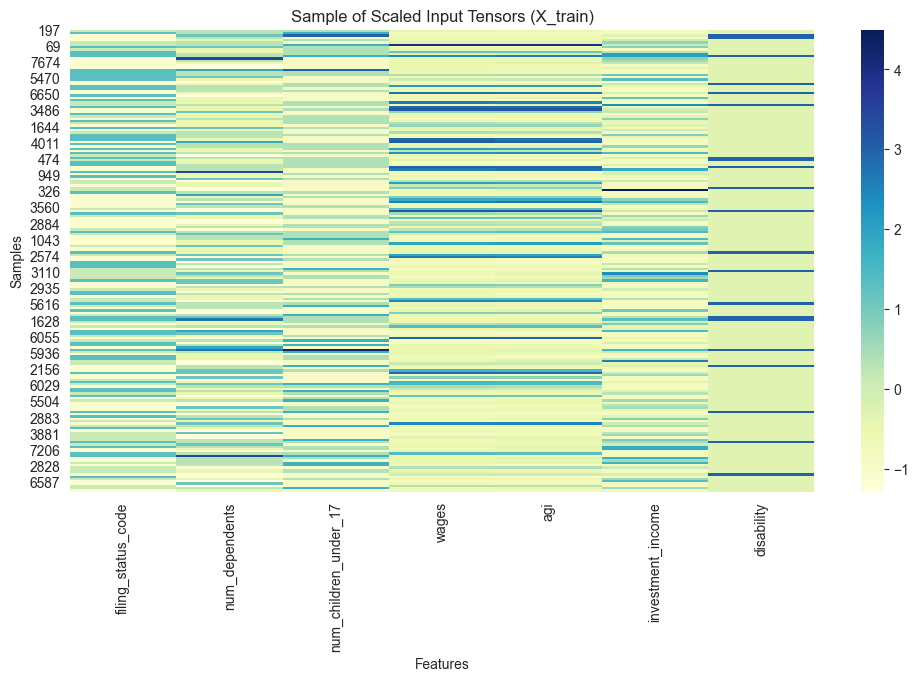

In [142]:
# Convert tensor to dataframe for easier heatmap
tensor_df = pd.DataFrame(X_train_tensor.numpy(), columns=features)

plt.figure(figsize=(12, 6))
sns.heatmap(tensor_df.sample(200), cmap="YlGnBu", xticklabels=True)
plt.title("Sample of Scaled Input Tensors (X_train)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

### Neural Weights

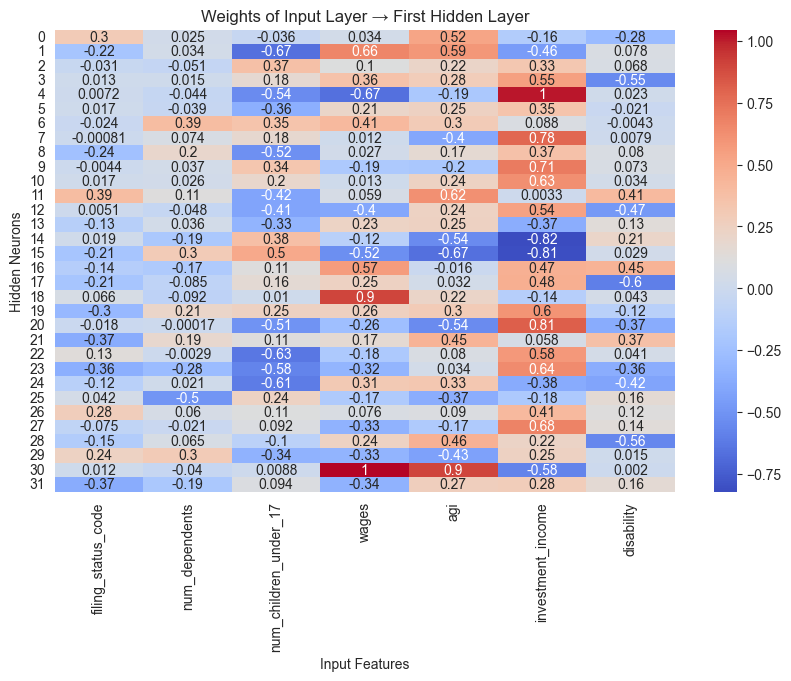

In [143]:
weights = model.net[0].weight.detach().numpy()

plt.figure(figsize=(10, 6))
sns.heatmap(weights, cmap="coolwarm", annot=True, xticklabels=features)
plt.title("Weights of Input Layer → First Hidden Layer")
plt.xlabel("Input Features")
plt.ylabel("Hidden Neurons")
plt.show()


### Embedding Space

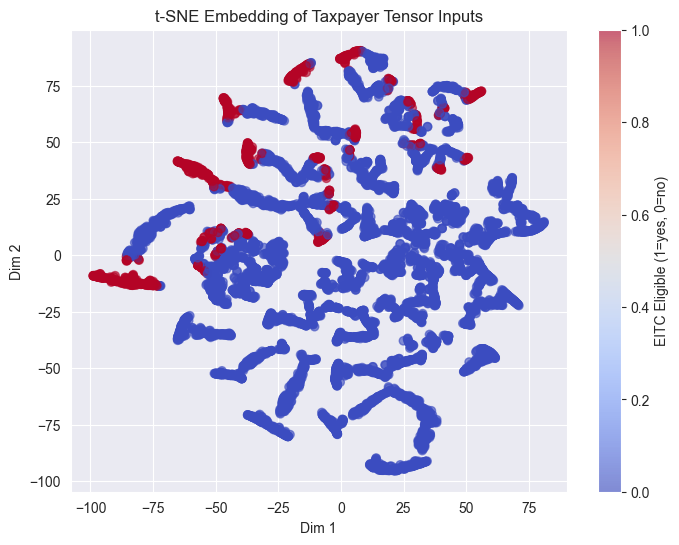

In [144]:
X_embedded = TSNE(n_components=2).fit_transform(X_train_tensor.numpy())

plt.figure(figsize=(8,6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train_tensor.numpy(), cmap="coolwarm", alpha=0.6)
plt.title("t-SNE Embedding of Taxpayer Tensor Inputs")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label="EITC Eligible (1=yes, 0=no)")
plt.show()

### Save the model

In [145]:
model_path = "models/eitc_classifier.pth"
torch.save(model.state_dict(), model_path)


joblib.dump(scaler, "models/scaler_eitc.joblib")
joblib.dump(features, "models/feature_list.joblib")

print(f"✅ Model saved to {model_path}")

✅ Model saved to models/eitc_classifier.pth


### Tensor Me

In [146]:
df["AGI"] = df["agi"].round(0)
df["Wages"] = df["wages"].round(0)
df["Investment_Income"] = df["investment_income"].round(0)
df["Capital_Gains"] = df["capital_gains"].round(0)

# Income quartile bins
df["Income_Group"] = pd.qcut(df["agi"], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])

# Clean binary fields
df["EITC_Eligible"] = df["claimed_eitc"].map({1: "Yes", 0: "No"})
df["CTC_Eligible"] = df["claimed_ctc"].map({1: "Yes", 0: "No"})
df["Disability_Label"] = df["disability"].map({1: "Yes", 0: "No"})

# Build full metadata DataFrame
metadata = pd.DataFrame({
    "EITC_Eligible": df["EITC_Eligible"],
    "CTC_Eligible": df["CTC_Eligible"],
    "Filing_Status": df["filing_status"],
    "Num_Dependents": df["num_dependents"],
    "Num_Under17": df["num_children_under_17"],
    "Disability": df["Disability_Label"],
    "AGI": df["AGI"],
    "Income_Group": df["Income_Group"],
    "Wages": df["Wages"],
    "Investment_Income": df["Investment_Income"],
    "Capital_Gains": df["Capital_Gains"],
    "Wages_To_Dependents": df["wages_to_dependents"],
    "AGI_Minus_Investments": df["agi_minus_investment"]
})

# Save to TensorFlow Projector-compatible TSV
metadata.to_csv("outputs/tax_metadata.tsv", sep="\t", index=False)
np.savetxt("outputs/tax_embeddings.tsv", X_scaled, delimiter="\t")

print("✅ Full metadata exported: outputs/tax_metadata.tsv")

✅ Full metadata exported: outputs/tax_metadata.tsv
